In [61]:
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow import keras

import cv2

import nibabel as nib

In [70]:
SEED = 909
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_TEST = 32

IMAGE_HEIGHT = 320
IMAGE_WIDTH_ORIG = 15
IMAGE_WIDTH = 16
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

# data_dir = 'data/slices/'
data_dir = '/home/lukas/datasets/prostate/Task05_Prostate/slices_dennis'
data_dir_train = os.path.join(data_dir, 'training')
# The images should be stored under: "data/slices/training/img/img"
data_dir_train_image = os.path.join(data_dir_train, 'img')
# The images should be stored under: "data/slices/training/mask/img"
data_dir_train_mask = os.path.join(data_dir_train, 'mask')

data_dir_test = os.path.join(data_dir, 'test')
# The images should be stored under: "data/slices/test/img/img"
data_dir_test_image = os.path.join(data_dir_test, 'img')
# The images should be stored under: "data/slices/test/mask/img"
data_dir_test_mask = os.path.join(data_dir_test, 'mask')

NUM_TRAIN = 15872
NUM_TEST = 4352

NUM_OF_EPOCHS = 100

In [71]:
def scaleImg(img, height, width):
    return cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_LINEAR)

In [72]:
def create_segmentation_generator_train(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255
#                      featurewise_center=True,
#                      featurewise_std_normalization=True,
#                      rotation_range=90
#                      width_shift_range=0.2,
#                      height_shift_range=0.2,
#                      zoom_range=0.3
                        )
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

# Remember not to perform any image augmentation in the test generator!
def create_segmentation_generator_test(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

In [73]:
train_generator = create_segmentation_generator_train(data_dir_train_image, data_dir_train_mask, BATCH_SIZE_TRAIN)
test_generator = create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, BATCH_SIZE_TEST)

Found 16334 images belonging to 2 classes.
Found 16334 images belonging to 2 classes.
Found 4492 images belonging to 2 classes.
Found 4492 images belonging to 2 classes.


In [66]:
imgPath = os.path.join(data_dir_train_image, 'img', 'prostate24-slice298_y.png')
# img = nib.load(imgPath).get_fdata()
img = cv2.imread(imgPath, 0) 
# img = img[:,:,:,0]

print(img.shape)

imgs = scaleImg(img, IMAGE_HEIGHT, IMAGE_WIDTH + 1)
imgs.shape

(320, 15)


(320, 16)

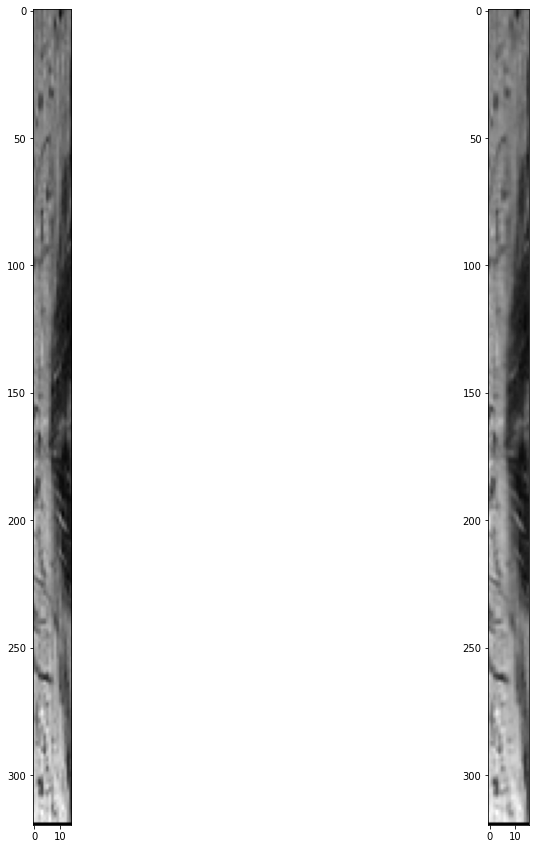

((320, 15), (320, 16))

In [68]:
# show input image slice
plt.figure(figsize=(15,15))
imgSlice = img
imgDimX, imgDimY = imgSlice.shape
imgSliceScaled = scaleImg(imgSlice, IMAGE_HEIGHT, IMAGE_WIDTH + 1)
plt.subplot(1,2,1)
plt.imshow(imgSlice, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(imgSliceScaled, cmap='gray')
plt.show()
imgSlice.shape, imgSliceScaled.shape

In [74]:
def display(display_list):
    plt.figure(figsize=(15,15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [75]:
def show_dataset(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        display([image[0], mask[0]])

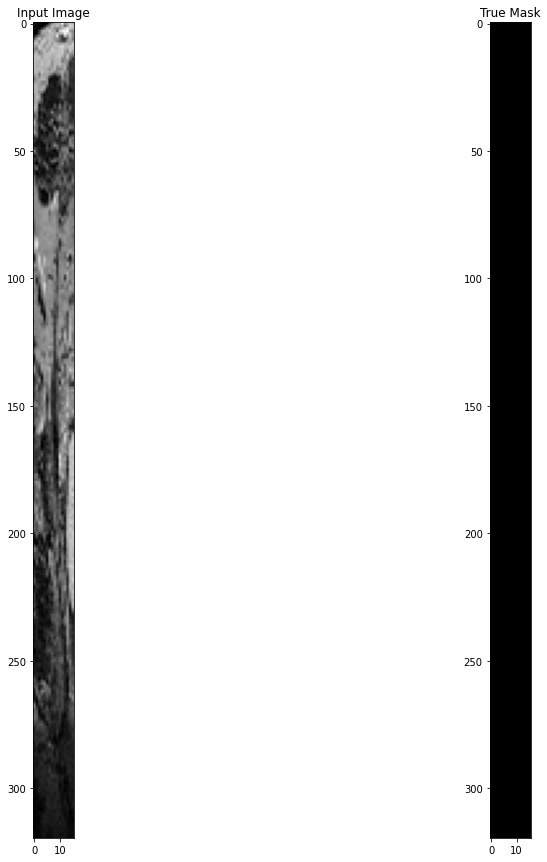

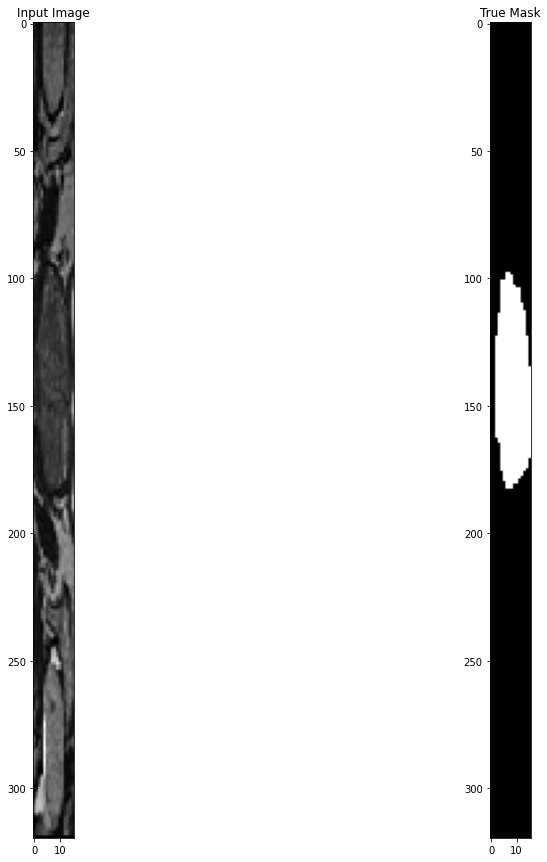

In [76]:
show_dataset(train_generator, 2)

In [77]:
def unet(n_levels, initial_features=32, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    # inputs = keras.layers.Input(shape=(320, 16, in_channels))
    x = inputs
    
    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')
    
    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
        if level < n_levels - 1:
            skips[level] = x
            x = keras.layers.MaxPool2D(pooling_size)(x)
           
    [print(l, sk.shape) for l, sk in skips.items()]
        
    # upstream
    for level in reversed(range(n_levels-1)):
        x = keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
        print(f"{level} - {x.shape} - {skips[level].shape}")
        x = keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
            
    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)
    
    return keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')

In [78]:
EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_TEST = NUM_TEST // BATCH_SIZE_TEST

model = unet(4)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

0 (None, 320, 16, 32)
1 (None, 160, 8, 64)
2 (None, 80, 4, 128)
2 - (None, 80, 4, 128) - (None, 80, 4, 128)
1 - (None, 160, 8, 64) - (None, 160, 8, 64)
0 - (None, 320, 16, 32) - (None, 320, 16, 32)


In [79]:
model.summary()

Model: "UNET-L4-F32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 320, 16, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_140 (Conv2D)             (None, 320, 16, 32)  320         input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_141 (Conv2D)             (None, 320, 16, 32)  9248        conv2d_140[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_42 (MaxPooling2D) (None, 160, 8, 32)   0           conv2d_141[0][0]                 
________________________________________________________________________________________

In [81]:
model.fit_generator(generator=train_generator, 
                    steps_per_epoch=EPOCH_STEP_TRAIN, 
                    validation_data=test_generator, 
                    validation_steps=EPOCH_STEP_TEST,
                   epochs=10)  # NUM_OF_EPOCHS

/home/lukas/anaconda3/envs/dicom-tf/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
496/496 [==============================] - 502s 1s/step - loss: 0.1396 - accuracy: 0.9697 - val_loss: 0.0337 - val_accuracy: 0.9807
Epoch 2/10
496/496 [==============================] - 512s 1s/step - loss: 0.0376 - accuracy: 0.9699 - val_loss: 0.0271 - val_accuracy: 0.9803
Epoch 3/10
496/496 [==============================] - 583s 1s/step - loss: 0.0257 - accuracy: 0.9712 - val_loss: 0.0256 - val_accuracy: 0.9812
Epoch 4/10
496/496 [==============================] - 530s 1s/step - loss: 0.0220 - accuracy: 0.9707 - val_loss: 0.0234 - val_accuracy: 0.9817
Epoch 5/10
496/496 [==============================] - 498s 1s/step - loss: 0.0167 - accuracy: 0.9728 - val_loss: 0.0262 - val_accuracy: 0.9808
Epoch 6/10
496/496 [==============================] - 485s 978ms/step - loss: 0.0152 - accuracy: 0.9733 - val_loss: 0.0315 - val_accuracy: 0.9817
Epoch 7/10
496/496 [==============================] - 484s 977ms/step - loss: 0.0123 - accuracy: 0.9736 - val_loss: 0.0237 - val_accuracy: 

In [82]:
model.save(f'UNET-ProstateSegmentation_{IMAGE_HEIGHT}_{IMAGE_WIDTH}.h5')

In [83]:
test_generator = create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, 1)

Found 4492 images belonging to 2 classes.
Found 4492 images belonging to 2 classes.


In [84]:
def show_prediction(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        pred_mask = model.predict(image)[0] > 0.5
        display([image[0], mask[0], pred_mask])

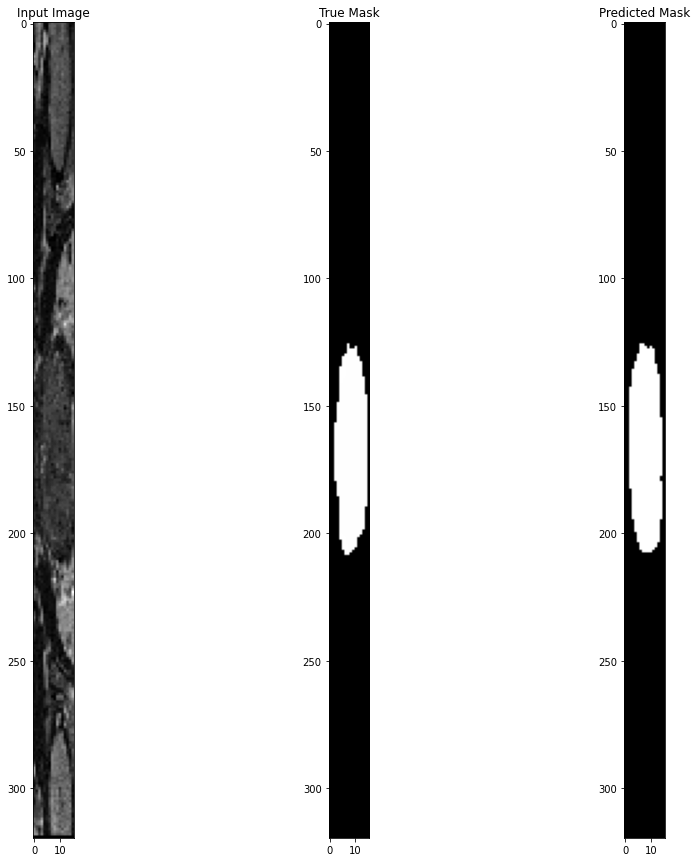

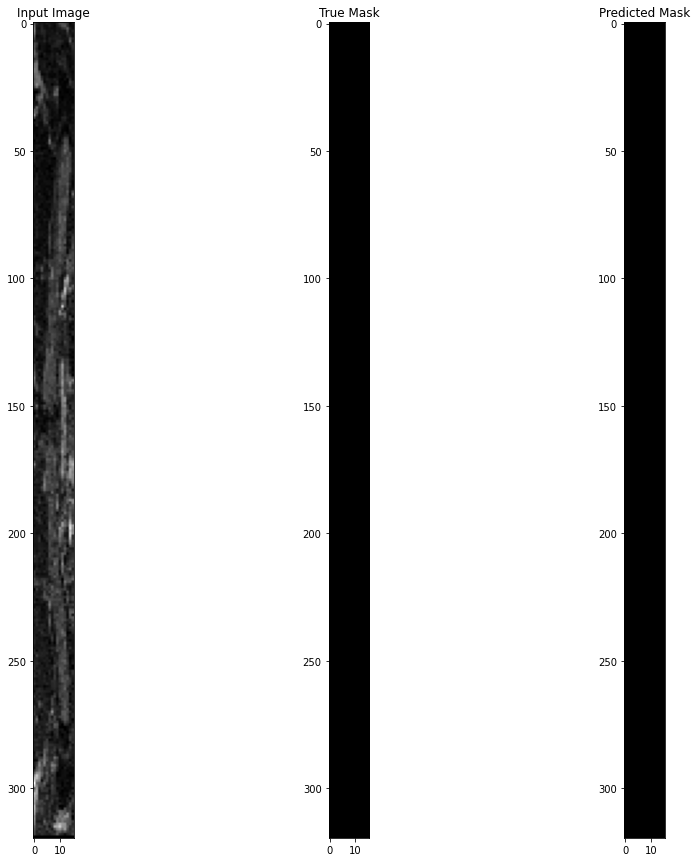

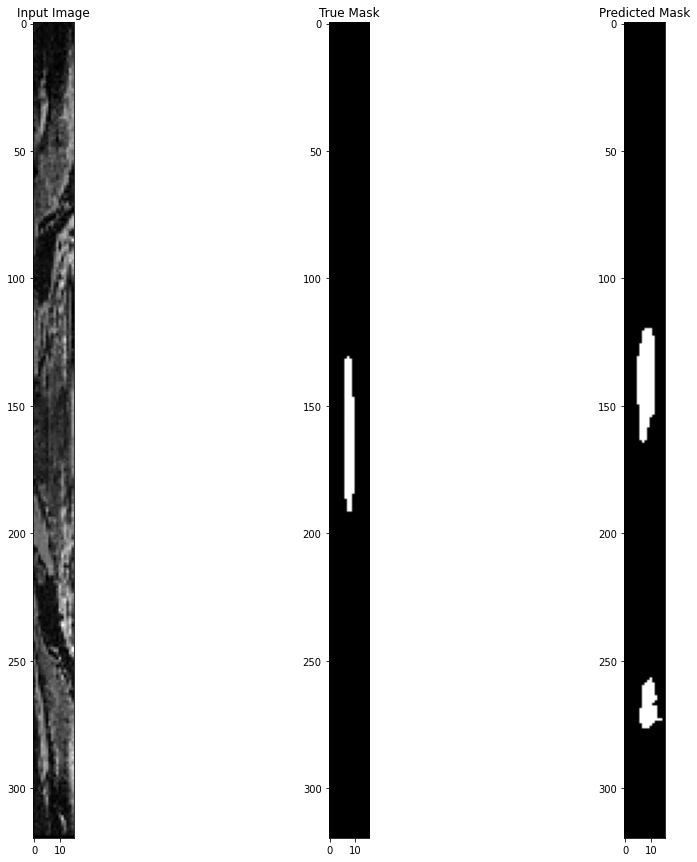

In [97]:
show_prediction(test_generator, 3)

In [86]:
image,mask = next(test_generator)
pred = model.predict(image)

In [92]:
pred[0].shape
image.shape
mask.shape
pred.shape

(1, 320, 16, 1)

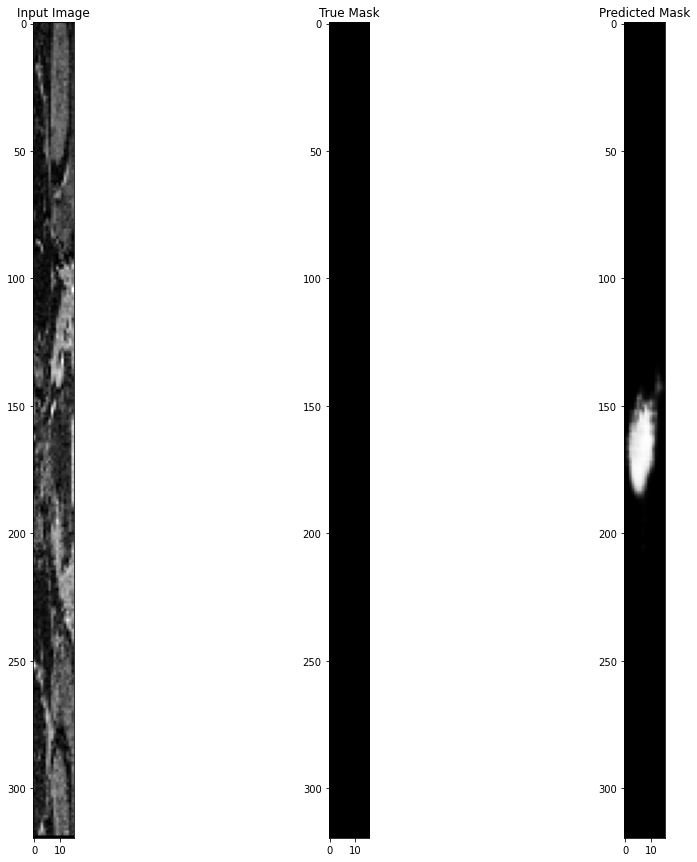

In [94]:
display([image[0], mask[0], pred[0]])